In [31]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tesla-stock-price:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1007%2F1814%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240314%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240314T134331Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db33230f96e6188ac77d454b5a2960c6bc1e3bb6840acbfdbb9773785df8711cf008ce2387a80dcfec679fecfee4fdf99bd17dbbdabf1f956de7f14a20aa9699b48d3d39653d37a6413d50cbf8a7bd3729176758ab6ec15cc14aa526bad4cc54322eaf08d179f77f1a09fa1696d7f341997fb12873998f2e4edb336bc8c8bdb5453939f3bb47f02bd8d6b5b3df46c04c7c5238597493a673880488ac8505956f02d1c6cc249c27435772dd8837da2284268339d6c9c5304e155529d46fc44f339886cbd2776df923b0d05467c87f51b0e155aaa10e1dbaece01bdfcda456c919ff43c234c53d72d6684c77f6559b3345df019c697ca9ccd657dbf07feb153b59c,sandp500:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1908%2F17155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240314%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240314T134331Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7ed71f0f4cfafc6bcd3ff3e09bf68e3e4ec1b49cd1dfbef0dc8752979314434e81a4f641b4cab7ba40afc1663e9ea39de8787ad44a2acc0ff62f5a35f09bfff1680549b72f7bada89c70369e0393a4957979669a65dcb122cf6a700b413b7681e2d01fea5ab1781800dd5fb9e70760f400e65916b4ddf6f23a27625589d731c4fe1306b041c06a98360ca7ebc67fab515d67391680effe0a26a8b034a65e19726dee634504ad79ea920cf5279e66704bde54d4b792da8ff7180379c0021939f40f6d939b2e9181cb3c44b5974c3acfc740865df51579ed7f48f5c0700371dc124a13d3335ba0ec8d34d75dae280d9a8003fa0a2914f245b9925d9dcb81993d9b,amzn-dpz-btc-ntfx-adjusted-may-2013may2019:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F195545%2F433077%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240314%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240314T134331Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0c3ad5e44617b70a9afe49e8619eb7cf7c45659f2ba87de61daa0cb73627429e698c2678048392ee82b20c49d9768a05d30b5f1f30cdae42341809e8e8bed3592c07003ede83129eabe1fa9038195c98344bc1bd19e31d3a1df97ce1a7c56aeaf123fe25501858d9f741e327706d68b7d4ee21a76c2a0541d85ffe5e18814a1dea9124e44c794840ebe5405c11aa93f009aa1347dc27b2f9b7c1c75d14f444bde382baa98c16040a63edc30d7fa7deeeddffd9350df8b046e59a856469e87b1cdb6ad857a28fd31be426ea4fb4a5226c1ca6ff224d0d401b4886753e9484a11e29bf5c77733d55c6db2ec0f600b6add925a06ea0da32eac25bd11136faaf5c15,apple-aapl-historical-stock-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F533900%2F976925%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240314%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240314T134331Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D93f8da48ae7208ed783e573214c65c2ed1cb544fefaef097cad9cd3c6369fb05dc03bf1ac78cb310e295d45888fee6c24dae03c8b313725bc7d582213c6f554c7e57a49a83af6ded265002dc639bf6b2f228d9ece613398ff79a61f841a964172e766af364cd88460712647aa2da72c943b22c8e4024f4a5323c0c6a9c3117dc850411c9d00af7d3a7be01c16d261777261209917b3c3f6405c753886ef249fd94889e577c71e03066fd1fbcb274bc965afdbe20034d3daaeaf9f3f18fb2033164d80f8dc5c1b4448b5ad8801e60b3326beb8180e495e61c37e7cfea76dfd536b75bb392ed44d055ec9137acfdba9c685121855cd22ffb4a15d79a8f5661386e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34499 bytes downloaded
Downloaded and uncompressed: tesla-stock-price
[==================================================] 20283917 bytes downloaded
Downloaded and uncompressed: sandp500
[==================================================] 30437 bytes downloaded
Downloaded and uncompressed: amzn-dpz-btc-ntfx-adjusted-may-2013may2019
[==================================================] 50651 bytes downloaded
Downloaded and uncompressed: apple-aapl-historical-stock-data
Data source import complete.


In [ ]:
!pip install -q yfinance

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-03-01,176.750000,178.729996,176.070007,178.220001,178.220001,31956200,AMAZON
2024-03-04,177.529999,180.139999,177.490005,177.580002,177.580002,37381500,AMAZON
2024-03-05,176.929993,176.929993,173.300003,174.119995,174.119995,37228300,AMAZON
2024-03-06,175.539993,176.460007,173.259995,173.509995,173.509995,32090900,AMAZON
2024-03-07,174.830002,177.990005,173.720001,176.820007,176.820007,34063300,AMAZON
2024-03-08,176.440002,178.789993,174.330002,175.350006,175.350006,37853500,AMAZON
2024-03-11,174.309998,174.470001,171.470001,171.960007,171.960007,28484800,AMAZON
2024-03-12,173.500000,176.759995,171.979996,175.389999,175.389999,36610600,AMAZON
2024-03-13,175.899994,177.619995,175.550003,176.559998,176.559998,30737500,AMAZON


In [ ]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,179.906799,181.374289,178.588103,180.096092,179.599133,5.720056e+07
std,10.614380,10.439071,10.528128,10.418514,10.534016,1.705695e+07
min,151.190002,153.250000,149.919998,152.589996,151.779831,6.745584e+06
25%,172.940002,174.029999,171.600006,173.000000,172.591095,4.677800e+07
50%,180.089996,181.929993,178.330002,180.570007,179.859726,5.337730e+07
75%,189.259995,189.990005,187.610001,189.300003,188.850006,6.384130e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.366826e+08


In [ ]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-03-14 to 2024-03-14
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          253 non-null    float64
 1   High          253 non-null    float64
 2   Low           253 non-null    float64
 3   Close         253 non-null    float64
 4   Adj Close     253 non-null    float64
 5   Volume        253 non-null    int64  
 6   company_name  253 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB


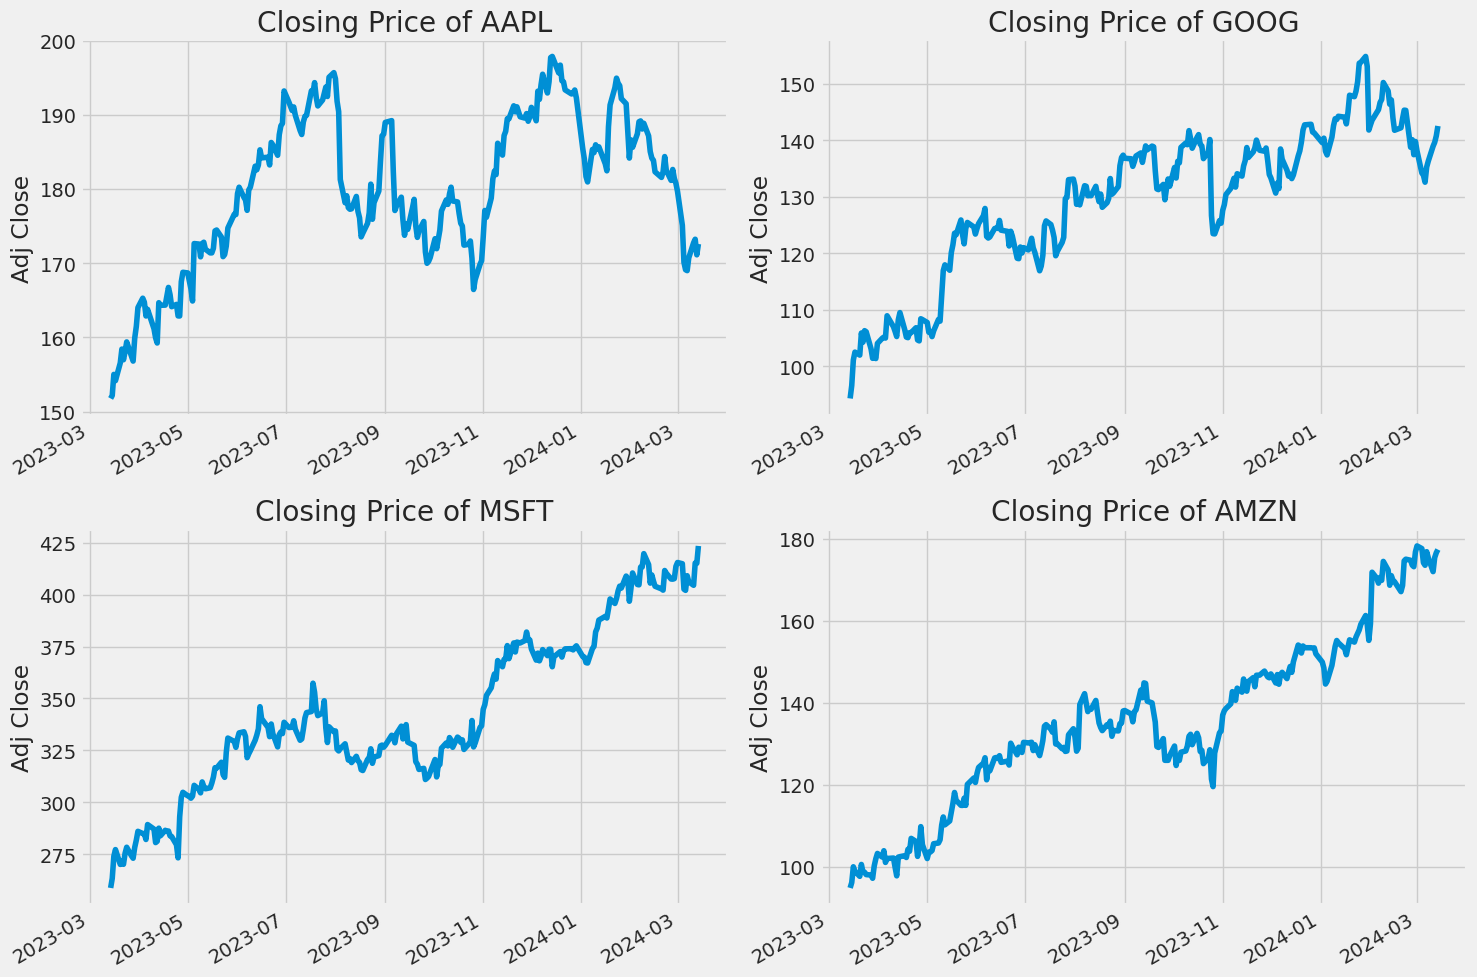

In [ ]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

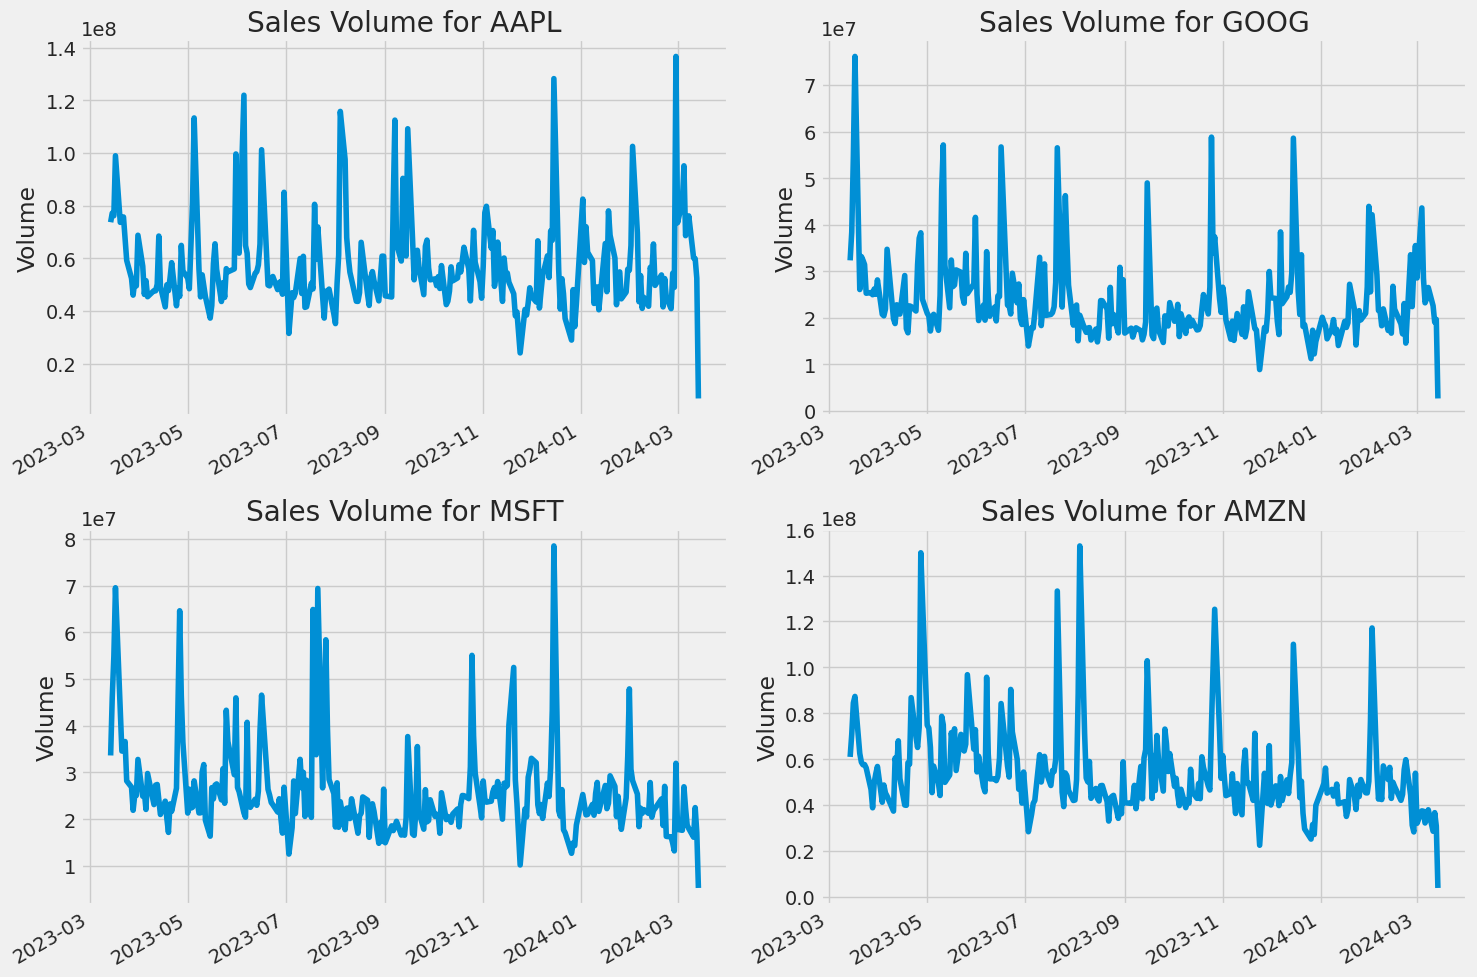

In [ ]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

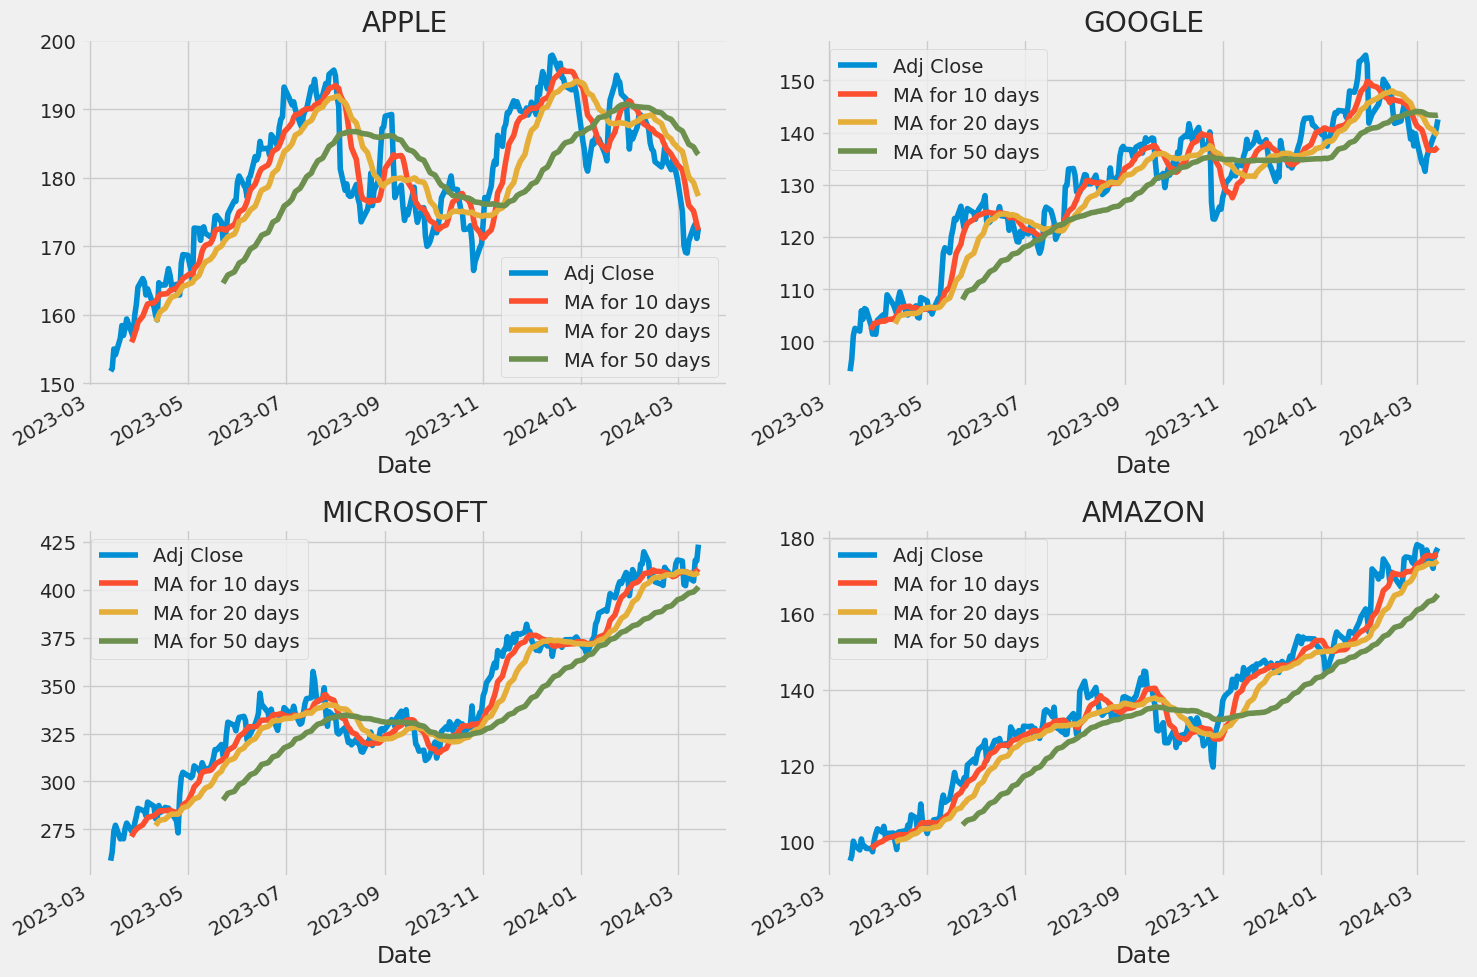

In [ ]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

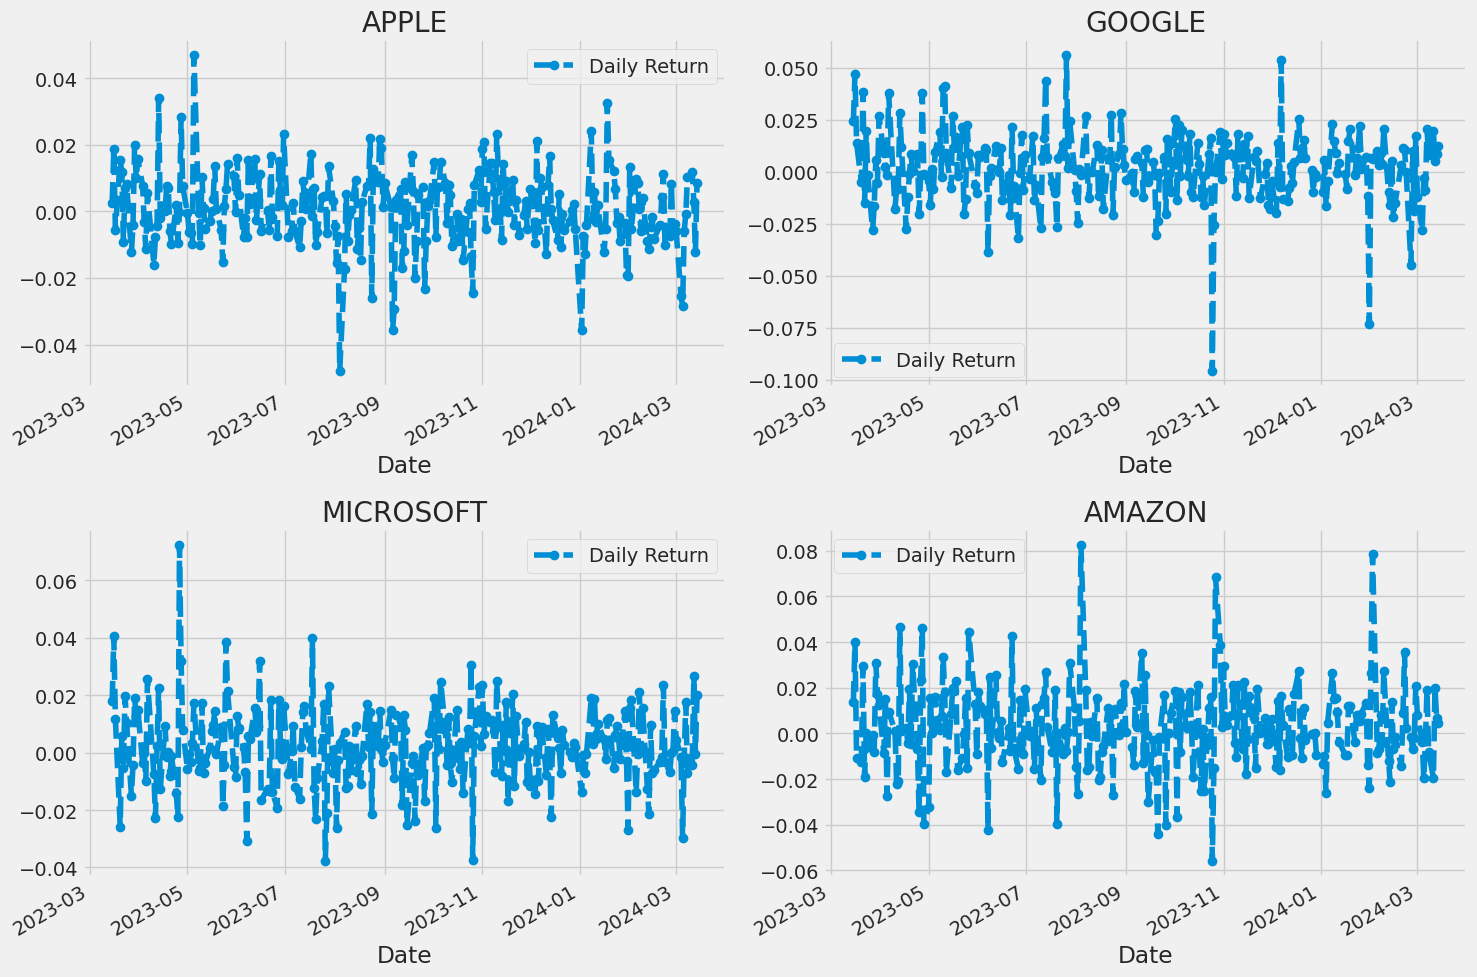

In [ ]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

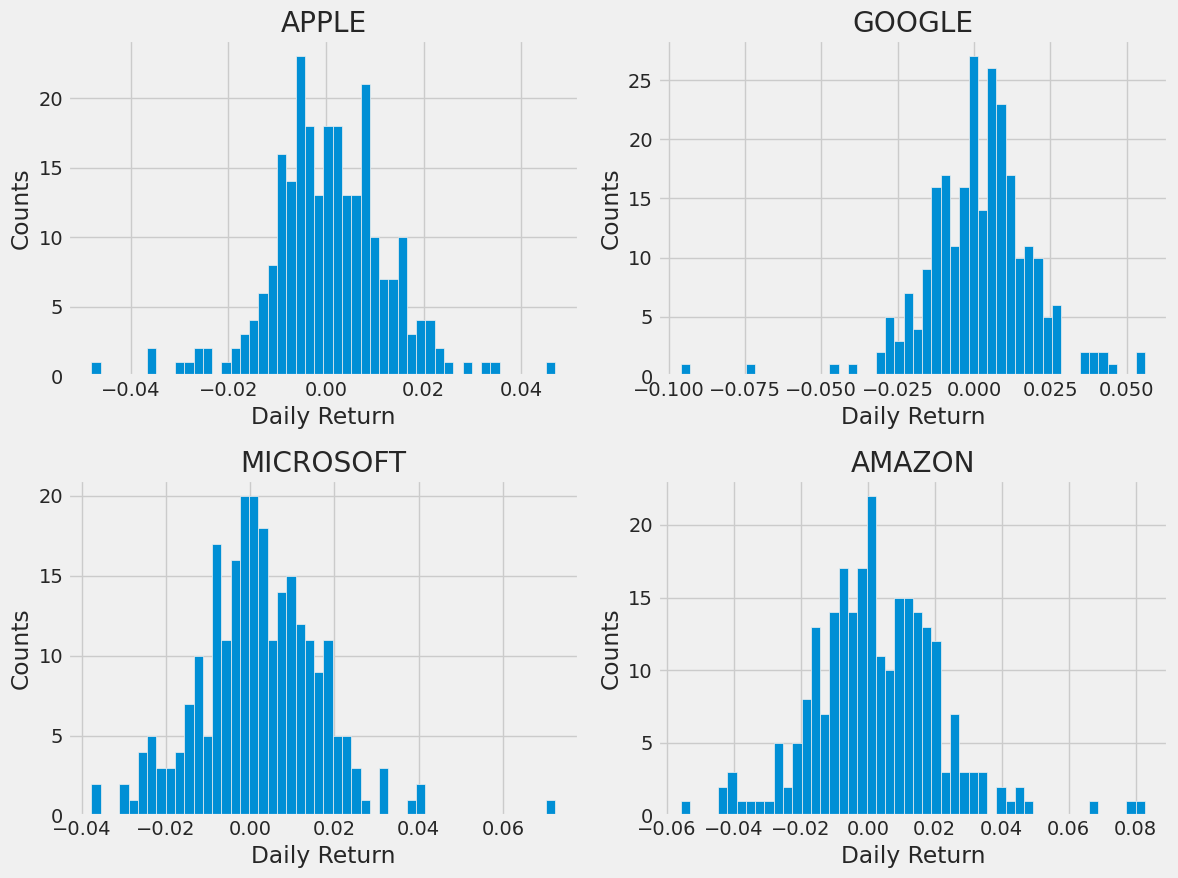

In [ ]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

In [ ]:

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']


tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-03-14,NaN,NaN,NaN,NaN
2023-03-15,0.002621,0.013912,0.024403,0.017831
2023-03-16,0.018694,0.039917,0.046815,0.040536
2023-03-17,-0.005454,-0.010896,0.013753,0.011694
2023-03-20,0.015484,-0.012532,-0.005173,-0.025767


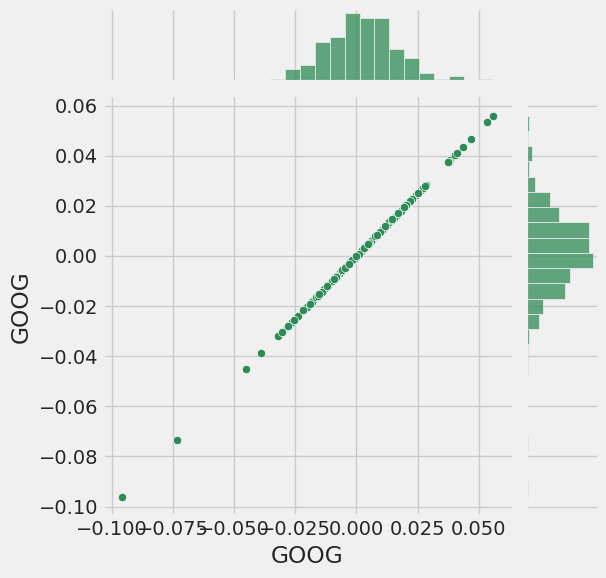

In [ ]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

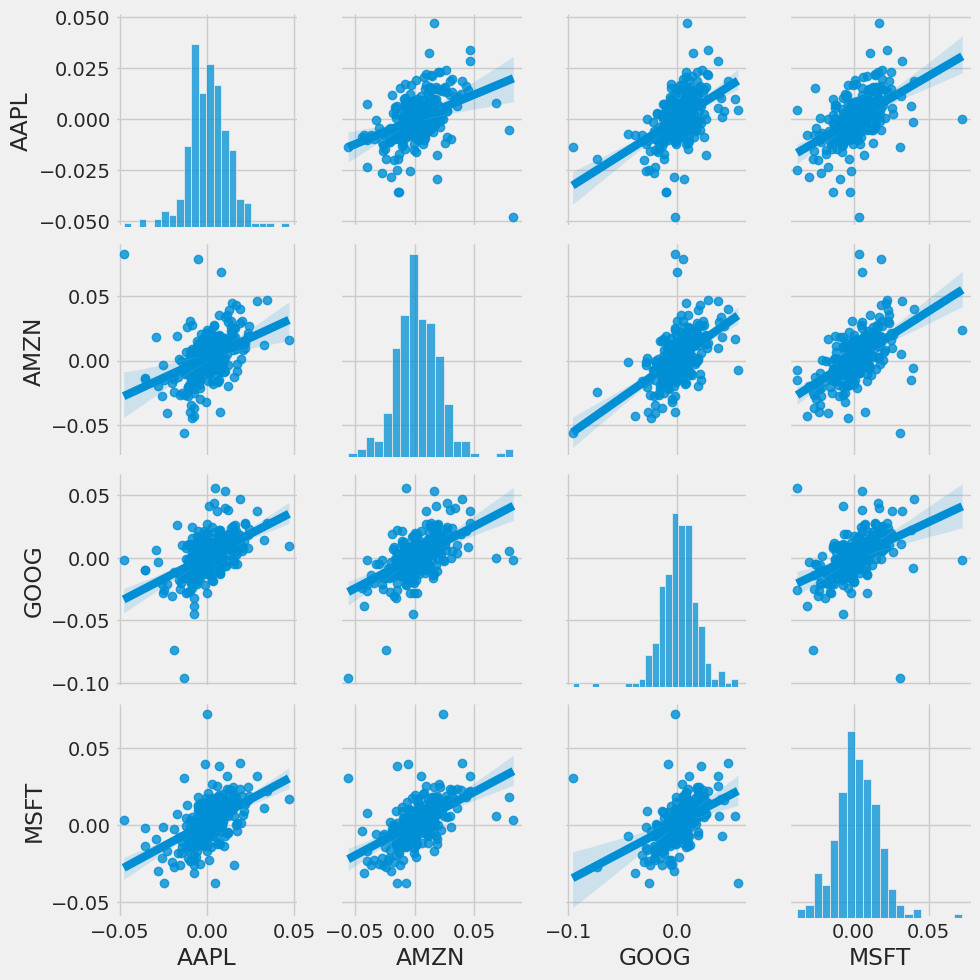

In [ ]:

sns.pairplot(tech_rets, kind='reg')

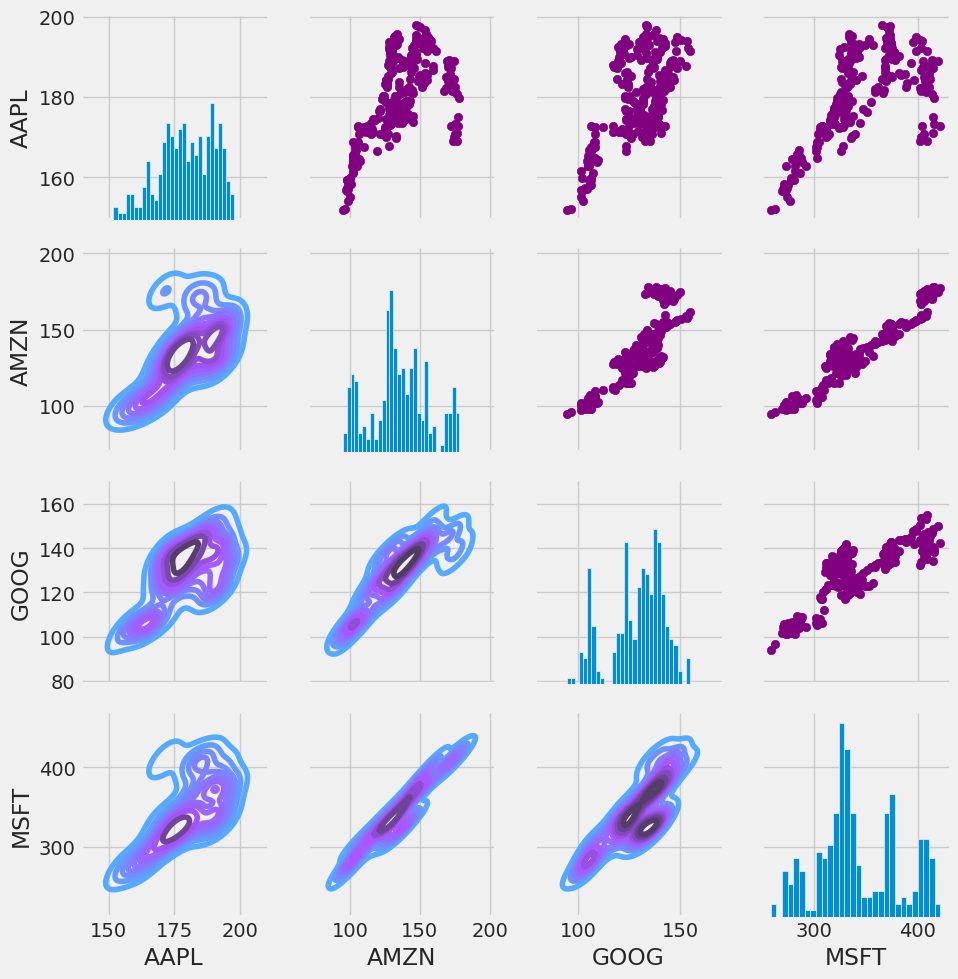

In [ ]:

returns_fig = sns.PairGrid(closing_df)
returns_fig.map_upper(plt.scatter,color='purple')

returns_fig.map_lower(sns.kdeplot,cmap='cool_d')


returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

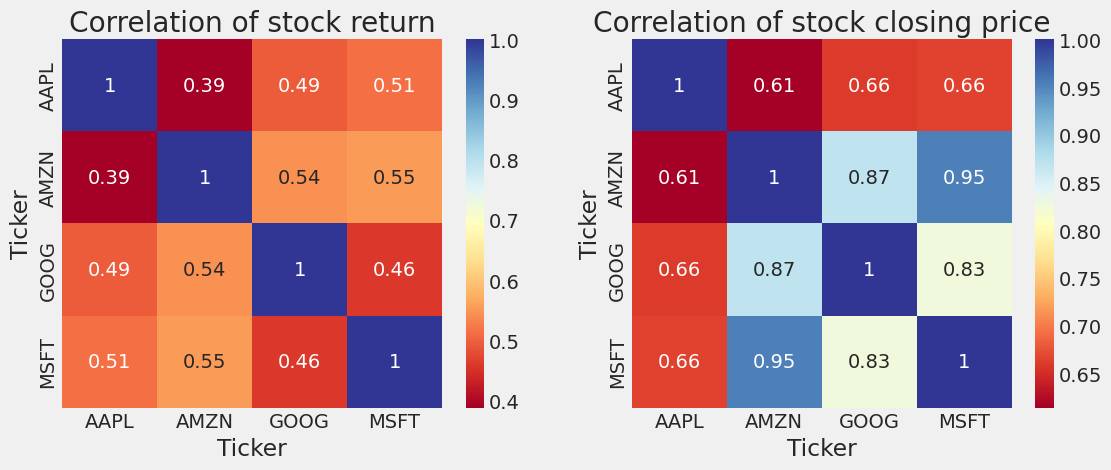

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='RdYlBu')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='RdYlBu')
plt.title('Correlation of stock closing price')

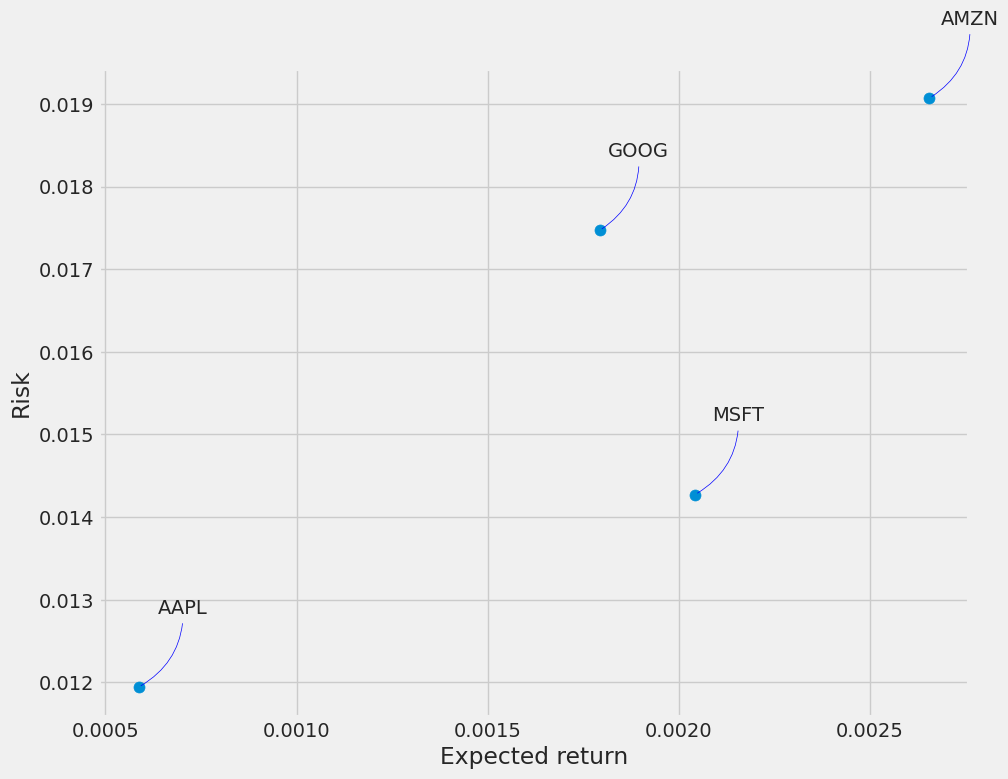

In [ ]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [ ]:

df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433825,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500646,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639429,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771558,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751299,394024400
...,...,...,...,...,...,...
2024-03-08,169.000000,173.699997,168.940002,170.729996,170.729996,76114600
2024-03-11,172.940002,174.380005,172.050003,172.750000,172.750000,60139500
2024-03-12,173.149994,174.029999,171.009995,173.229996,173.229996,59825400


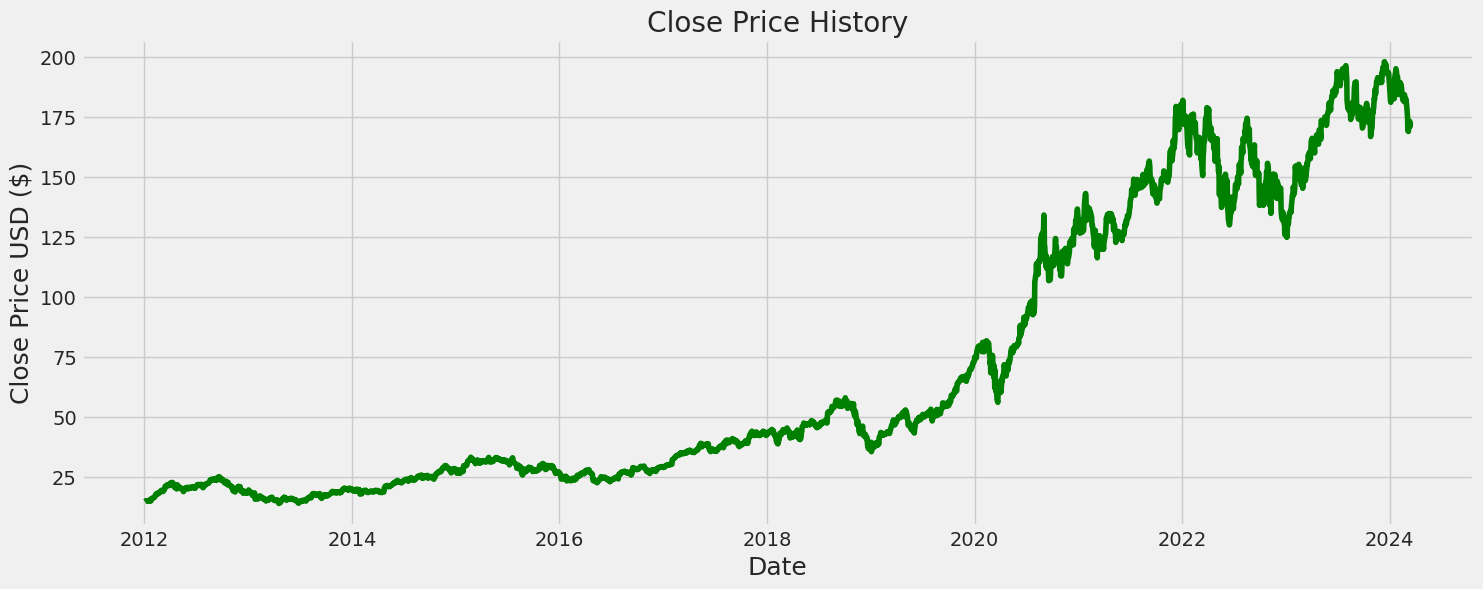

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'], color='green')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:

data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

2916

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.86490189],
       [0.85349897],
       [0.86245842]])

In [ ]:

train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.0

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM


model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(x_train, y_train, batch_size=1, epochs=1)

2856/2856 [==============================] - 217s 74ms/step - loss: 0.0011


In [ ]:

test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])


x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 1s 40ms/step


8.545453843934032

<ipython-input-28-6ad9ae8e66d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


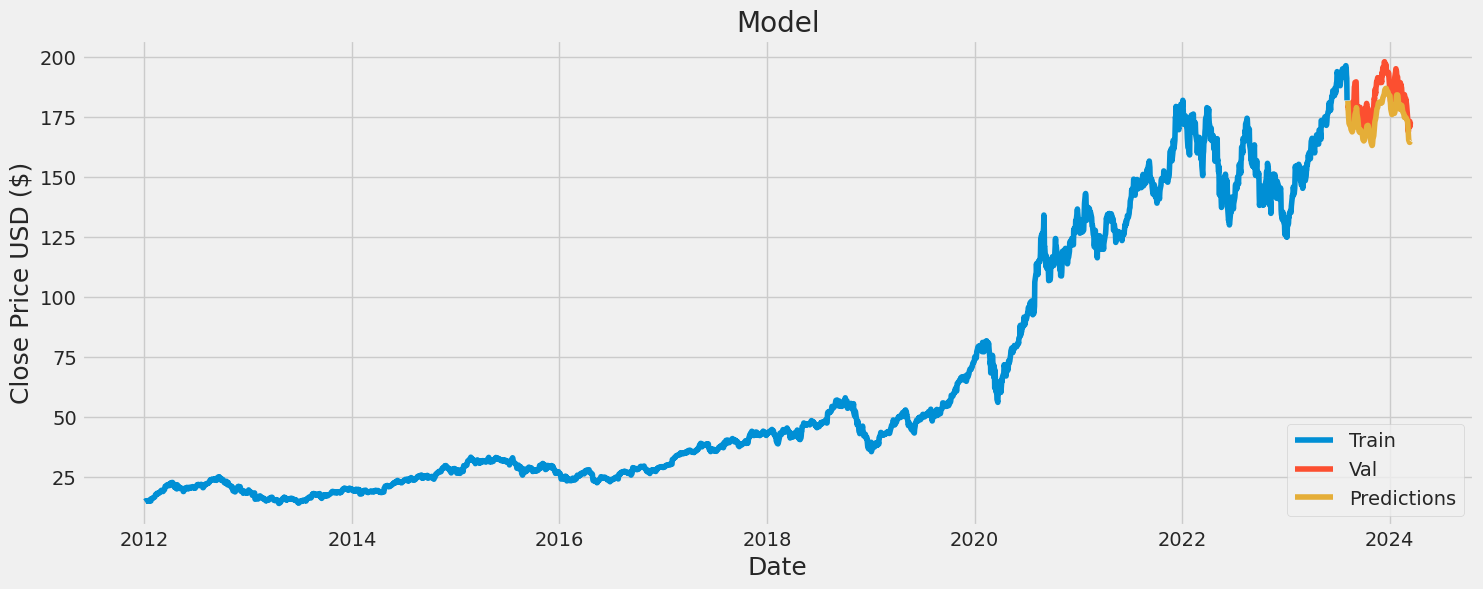

In [ ]:


train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()